In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os # path
from glob import glob # search file paths
from tqdm.auto import tqdm # (optional) progress bar
from sklearn.model_selection import train_test_split

# PyTorch
import torch
from torch import nn
import torchvision
from torchsummary import summary # model summary

torch.__version__

'2.2.1+cu121'

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


#### Download dataset

In [3]:
# download from google drive
!pip install --upgrade gdown
!gdown --fuzzy 1fIViA1w8MVJJZJcAjMwapHIYazuyTczE --output pneumonia.zip
# unzip dataset file
!unzip -q pneumonia.zip

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
Downloading...
From (original): https://drive.google.com/uc?id=1fIViA1w8MVJJZJcAjMwapHIYazuyTczE
From (redirected): https://drive.google.com/uc?id=1fIViA1w8MVJJZJcAjMwapHIYazuyTczE&confirm=t&uuid=ebd02957-366c-43b3-8381-e2e184e4f335
To: /content/pneumonia.zip
100% 118M/118M [00:01<00:00, 73.0MB/s]


### Data

#### Check your data first

In [4]:
IMG_SIZE = 256 # 32x, 16x
all_class = ['normal', 'bacteria', 'virus']
class_map = {cls: i for i, cls in enumerate(all_class)}
#  'normal':0, 'bacteria': 1, 'virus':2
class_map

{'normal': 0, 'bacteria': 1, 'virus': 2}

In [5]:
# read all paths
# *: all
img_paths_train = sorted(glob('pneumonia/train/*/*.jpeg'))
# img_paths_train = glob('pneumonia/train/normal/*.jpeg') + glob('pneumonia/train/pneumonia/*.jpeg')

img_paths_test = sorted(glob('pneumonia/val/*/*.jpeg'))

In [6]:
img_paths_train[:3]

['pneumonia/train/normal/IM-0158-0001.jpeg',
 'pneumonia/train/normal/IM-0164-0001.jpeg',
 'pneumonia/train/normal/IM-0199-0001.jpeg']

In [7]:
# number of images
len(img_paths_train), len(img_paths_test)

(150, 100)

pneumonia/train/pneumonia/person1010_virus_1695.jpeg
(307, 502, 3)


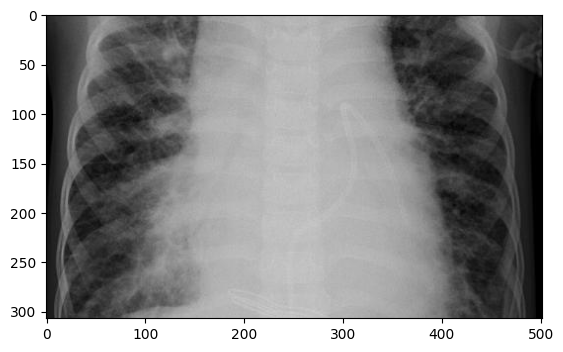

In [8]:
# show image
path = img_paths_train[100]
img = cv2.imread(path)
print(path)
print(img.shape)
plt.imshow(img)
plt.show()

In [9]:
# Extract img class
# os.sep: /
print(path)
print(path.split(os.sep))
cls = path.split(os.sep)[-2]
print(cls)

pneumonia/train/pneumonia/person1010_virus_1695.jpeg
['pneumonia', 'train', 'pneumonia', 'person1010_virus_1695.jpeg']
pneumonia


In [10]:

# Get file class index

# for pneumonia class
if cls == 'pneumonia':
    # get filename
    filename = path.split(os.sep)[-1]
    print(filename)
    # get pneumonia class
    cls_pneumonia = filename.split('_')[1]
    print(cls_pneumonia)
    cls_idx = class_map[cls_pneumonia]
    print(cls_idx)
# for normal class
else:
    cls_idx = class_map[cls]

person1010_virus_1695.jpeg
virus
2


In [11]:
cls_idx

2

#### Dataset & DataLoader


*   [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset)



*   Must implement

    1.   **\_\_len\_\_()**: size of dataset
    2.   **\_\_getitem\_\_()**: load a data sample for a given index

*   __getitem__() steps:
    1. Get image path
    2. Read image, resize
    3. Real image label
    4. convert image to tesnor and rescale to 0~1


ref: [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)


Pixel value rescale

*   0~1
*   -1~+1 : (x/127.5) - 1
* (x-x.mean()) / x.std()

In [12]:
class PneumoniaDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, img_size, class_map):
        self.img_paths = img_paths
        self.img_size = img_size
        self.class_map = class_map

    def __len__(self):
        """number of samples"""
        return len(self.img_paths)

    def __getitem__(self, idx):
        """read 1 sample"""
        # Read img
        path = self.img_paths[idx] # get img path
        img = cv2.imread(path) # read img
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
        img = cv2.resize(img, (self.img_size, self.img_size)) # Resize iamge
        img = img / 255. # 0~255 -> 0.~1.

        # Read class index
        cls = path.split(os.sep)[-2]
        # for pneumonia class
        if cls == 'pneumonia':
            # get filename
            filename = path.split(os.sep)[-1]
            # get pneumonia class
            cls = filename.split('_')[1]
        cls_idx = self.class_map[cls]

        # transform img to tensor
        img = torch.tensor(img, dtype=torch.float)
        # channel last -> channel first
        # np.swapaxis()
        img = img.permute(2, 0, 1) # (H, W, C) -> (C, H, W)

        cls_idx = torch.tensor(cls_idx, dtype=torch.long)
        return img, cls_idx

In [13]:
# Build dataset
train_ds = PneumoniaDataset(img_paths_train, IMG_SIZE, class_map)
val_ds = PneumoniaDataset(img_paths_test, IMG_SIZE, class_map)

In [14]:
# Number of samples
len(train_ds), len(val_ds)

(150, 100)

torch.Size([3, 256, 256]) tensor(0) normal


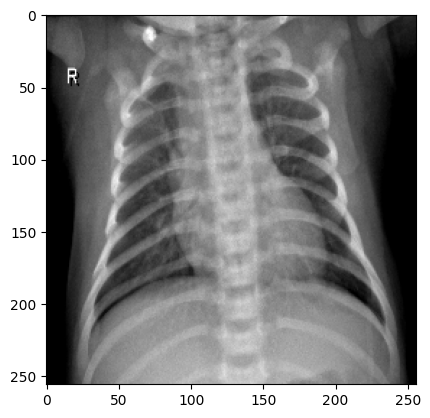

In [15]:
img, label = train_ds[0]
print(img.shape, label, all_class[label])

img = img.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
plt.imshow(img)
plt.show()

In [ ]:
img, label

(tensor([[[0.0980, 0.0980, 0.0980],
          [0.0706, 0.0706, 0.0706],
          [0.0588, 0.0588, 0.0588],
          ...,
          [0.1451, 0.1451, 0.1451],
          [0.1373, 0.1373, 0.1373],
          [0.1490, 0.1490, 0.1490]],
 
         [[0.1020, 0.1020, 0.1020],
          [0.0745, 0.0745, 0.0745],
          [0.0745, 0.0745, 0.0745],
          ...,
          [0.1686, 0.1686, 0.1686],
          [0.1451, 0.1451, 0.1451],
          [0.1373, 0.1373, 0.1373]],
 
         [[0.1725, 0.1725, 0.1725],
          [0.1647, 0.1647, 0.1647],
          [0.1686, 0.1686, 0.1686],
          ...,
          [0.1569, 0.1569, 0.1569],
          [0.1451, 0.1451, 0.1451],
          [0.1412, 0.1412, 0.1412]],
 
         ...,
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0

In [16]:
# Build DataLoaders
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE)

In [17]:
for (x, y) in train_loader:
    print(x.shape, y.shape)
    print(y)
    break

torch.Size([32, 3, 256, 256]) torch.Size([32])
tensor([0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0])


### Model



*   Must implement
    1.   **\_\_init\_\_**(): layer **initialization**
    2.   **forward**(): connect **Input** to **Output**



*   Model architecture
    1.   Feature extractor (encoder)
    2.   Flatten
    3.   Classifier



In [ ]:
kernel_size = 3
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32,
        kernel_size=kernel_size,
        padding='same'),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2), # img_size/2

    nn.Conv2d(32, 64, kernel_size, padding='same'),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2), # img_size/4

    nn.Conv2d(64, 128, kernel_size, padding='same'),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2), # img_size/8

    nn.Conv2d(128, 256, kernel_size, padding='same'),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2), # img_size/16

    nn.Flatten(), # C, H, W -> C*H*W

    nn.Linear(256*16*16, 3),
)

In [18]:
# Define Model class
class CNN(nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=kernel_size,
                      padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # img_size/2

            nn.Conv2d(32, 64, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2), # img_size/4

            nn.Conv2d(64, 128, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2), # img_size/8

            nn.Conv2d(128, 256, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2), # img_size/16

            nn.Conv2d(256, 512, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2), # img_size/32
        )
        self.flatten = nn.Flatten() # (512, 8, 8) -> (512*8*8)
        self.classifier = nn.Sequential(
            nn.Linear(512*8*8, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
        )

    def forward(self, x):
        x = self.feature_extractor(x) # img to feature maps
        x = self.flatten(x) # feature maps -> feature vectors
        x = self.classifier(x) # classification
        return x

In [19]:
# Build a model and move to GPU device
model = CNN(kernel_size=5).to(device)

In [20]:
print(model)

CNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (16): ReLU()
    (17): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=same

In [ ]:
# Model summary
summary(model, (3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]           2,432
              ReLU-2         [-1, 32, 256, 256]               0
            Conv2d-3         [-1, 32, 256, 256]          25,632
              ReLU-4         [-1, 32, 256, 256]               0
         MaxPool2d-5         [-1, 32, 128, 128]               0
            Conv2d-6         [-1, 64, 128, 128]          51,264
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]         102,464
              ReLU-9         [-1, 64, 128, 128]               0
        MaxPool2d-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         204,928
             ReLU-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]         409,728
             ReLU-14          [-1, 128,

### Training

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [ ]:
EPOCHS = 100
logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0000     train_loss: 1.1274, train_acc: 0.113     val_loss: 1.0993, val_acc: 0.220 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 1.1169, train_acc: 0.113     val_loss: 1.0975, val_acc: 0.220 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0002     train_loss: 1.1066, train_acc: 0.113     val_loss: 1.0960, val_acc: 0.220 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0003     train_loss: 1.0957, train_acc: 0.113     val_loss: 1.0946, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0004     train_loss: 1.0870, train_acc: 0.667     val_loss: 1.0935, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0005     train_loss: 1.0772, train_acc: 0.667     val_loss: 1.0926, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0006     train_loss: 1.0675, train_acc: 0.667     val_loss: 1.0918, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0007     train_loss: 1.0583, train_acc: 0.667     val_loss: 1.0913, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0008     train_loss: 1.0514, train_acc: 0.667     val_loss: 1.0909, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0009     train_loss: 1.0422, train_acc: 0.667     val_loss: 1.0908, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0010     train_loss: 1.0369, train_acc: 0.667     val_loss: 1.0908, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0011     train_loss: 1.0241, train_acc: 0.667     val_loss: 1.0910, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0012     train_loss: 1.0168, train_acc: 0.667     val_loss: 1.0914, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0013     train_loss: 1.0114, train_acc: 0.667     val_loss: 1.0920, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0014     train_loss: 1.0011, train_acc: 0.667     val_loss: 1.0928, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0015     train_loss: 0.9933, train_acc: 0.667     val_loss: 1.0938, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0016     train_loss: 0.9848, train_acc: 0.667     val_loss: 1.0951, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0017     train_loss: 0.9822, train_acc: 0.667     val_loss: 1.0964, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0018     train_loss: 0.9739, train_acc: 0.667     val_loss: 1.0981, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0019     train_loss: 0.9642, train_acc: 0.667     val_loss: 1.1001, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0020     train_loss: 0.9526, train_acc: 0.667     val_loss: 1.1025, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0021     train_loss: 0.9542, train_acc: 0.667     val_loss: 1.1051, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0022     train_loss: 0.9440, train_acc: 0.667     val_loss: 1.1081, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0023     train_loss: 0.9351, train_acc: 0.667     val_loss: 1.1116, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0024     train_loss: 0.9347, train_acc: 0.667     val_loss: 1.1155, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0025     train_loss: 0.9205, train_acc: 0.667     val_loss: 1.1202, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0026     train_loss: 0.9175, train_acc: 0.667     val_loss: 1.1253, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0027     train_loss: 0.9041, train_acc: 0.667     val_loss: 1.1315, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0028     train_loss: 0.9074, train_acc: 0.667     val_loss: 1.1379, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0029     train_loss: 0.8905, train_acc: 0.667     val_loss: 1.1457, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0030     train_loss: 0.8828, train_acc: 0.667     val_loss: 1.1546, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0031     train_loss: 0.8925, train_acc: 0.667     val_loss: 1.1629, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0032     train_loss: 0.8669, train_acc: 0.667     val_loss: 1.1737, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0033     train_loss: 0.8797, train_acc: 0.667     val_loss: 1.1830, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0034     train_loss: 0.8766, train_acc: 0.667     val_loss: 1.1922, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0035     train_loss: 0.8612, train_acc: 0.667     val_loss: 1.2033, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0036     train_loss: 0.8596, train_acc: 0.667     val_loss: 1.2144, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0037     train_loss: 0.8731, train_acc: 0.667     val_loss: 1.2220, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0038     train_loss: 0.8532, train_acc: 0.667     val_loss: 1.2327, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0039     train_loss: 0.8497, train_acc: 0.667     val_loss: 1.2426, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0040     train_loss: 0.8584, train_acc: 0.667     val_loss: 1.2499, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0041     train_loss: 0.8492, train_acc: 0.667     val_loss: 1.2574, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0042     train_loss: 0.8562, train_acc: 0.667     val_loss: 1.2625, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0043     train_loss: 0.8565, train_acc: 0.667     val_loss: 1.2670, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0044     train_loss: 0.8498, train_acc: 0.667     val_loss: 1.2716, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0045     train_loss: 0.8587, train_acc: 0.667     val_loss: 1.2735, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Logs

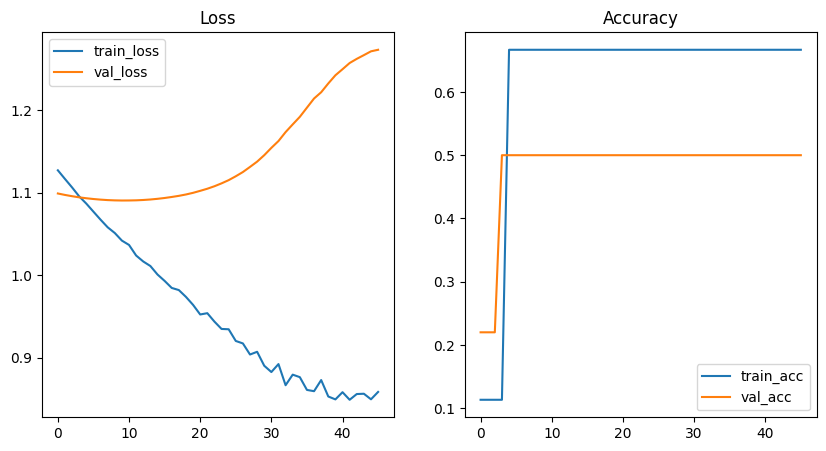

In [ ]:
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.legend(['train_loss', 'val_loss'])
# plot acc
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(logs['train_acc'])
plt.plot(logs['val_acc'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

#### Save and load the model



1.   Save model weights only
2.   Save with model class architecture



1. Save model weights only

In [ ]:
# Save model weights
PATH = './model_weights.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
# load model weights
model = CNN(kernel_size=7)
model.load_state_dict(torch.load(PATH))

2. Save with model class architecture

In [ ]:
torch.save(model, 'model.pth')

model = torch.load('model.pth')

#### Evaluation

In [ ]:
model = model.to(device) # move model to GPU
model.eval() # Set model to evaluation mode
# Create temp tensor
y_true = torch.tensor([], dtype=torch.long).to(device)
y_pred_logits = torch.tensor([]).to(device)

# deactivate autograd engine and reduce memory usage and speed up computations
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        pred = model(x)
        # Concatenate Ground truth and prediction
        y_true = torch.cat((y_true, y), dim=0)
        y_pred_logits = torch.cat((y_pred_logits, pred), dim=0)

y_pred_cls = y_pred_logits.argmax(1) # get class idx with max prob (100, 3) -> (100, )
y_pred_probs = nn.Softmax(dim=1)(y_pred_logits) # convert logits to probability

# Move tensor to CPU and convert to np.ndarray
y_true = y_true.cpu().numpy()
y_pred_cls = y_pred_cls.cpu().numpy()
y_pred_probs = y_pred_probs.cpu().numpy()


In [ ]:
# Shape
y_true.shape, y_pred_probs.shape, y_pred_cls.shape

In [ ]:
# calculate ACC.
acc = sum(y_true == y_pred_cls) / len(y_true)
acc

#### Another dataset using PIL.Image

In [ ]:
from PIL import Image
import torchvision.transforms as T

class PneumoniaDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, img_size, class_map):
        self.img_paths = img_paths
        self.img_size = img_size
        self.class_map = class_map
        self.transform = T.ToTensor()

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Read img
        path = self.img_paths[idx] # get img path
        img = Image.open(path).convert("RGB")
        img = img.resize((self.img_size, self.img_size))

        # Read class index
        cls = path.split(os.sep)[-2]
        # for pneumonia class
        if cls == 'pneumonia':
            # get filename
            filename = path.split(os.sep)[-1]
            # get pneumonia class
            cls = filename.split('_')[1]
        cls_idx = self.class_map[cls]

        # transform to tensor
        img = self.transform(img)
        cls_idx = torch.tensor(cls_idx, dtype=torch.long)

        return img, cls_idx